In [3]:
# --- 1. Import Necessary Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Import from scikit-learn and TensorFlow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# --- 2. Data Loading and Initial Exploration ---
# This part is for Google Colab. If running locally, you can replace
# this with: df = pd.read_csv('path/to/your/file.csv')
print("Please upload your 'control_surface_vibration_modes_100k.csv' file.")
uploaded = files.upload()

# Load the uploaded file into a DataFrame
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("\nDataset shape:", df.shape)
print("First 5 rows of the dataset:")
print(df.head())

Please upload your 'control_surface_vibration_modes_100k.csv' file.


Saving control_surface_vibration_modes_100k.csv to control_surface_vibration_modes_100k.csv

Dataset shape: (100000, 10)
First 5 rows of the dataset:
  Surface_Type     Material  Length_m  Width_m  Thickness_m  Airspeed_mps  \
0       Rudder     Titanium      1.93     0.28        0.020         174.6   
1       Rudder  CarbonFiber      1.00     0.49        0.027         219.1   
2     Elevator     Titanium      1.40     0.44        0.025          93.5   
3     Elevator  CarbonFiber      1.63     0.29        0.010         179.5   
4      Aileron     Titanium      1.64     0.38        0.029         195.9   

   Angle_of_Attack_deg  Mode_Number  Natural_Freq_Hz  Damping_Ratio  
0                 13.5            3            15.27          0.031  
1                 11.8            1            12.60          0.026  
2                  8.4            3            17.54          0.038  
3                 -4.2            3            14.80          0.034  
4                  1.6            2  

In [4]:
# --- 3. Data Preprocessing for Multi-Output Regression ---

# One-hot encode categorical features ('Surface_Type', 'Material')
df_processed = pd.get_dummies(df, columns=['Surface_Type', 'Material'], drop_first=True)
print("\nDataset shape after one-hot encoding:", df_processed.shape)

# Define Features (X) and Targets (y) using the correct column names from your dataset
X = df_processed.drop(columns=['Natural_Freq_Hz', 'Damping_Ratio'])
y = df_processed[['Natural_Freq_Hz', 'Damping_Ratio']]

# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the Features and Targets
feature_scaler = StandardScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

# Reshape features for LSTM input: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print("\nShape of training data for LSTM:", X_train_lstm.shape)
print("Shape of test data for LSTM:", X_test_lstm.shape)


Dataset shape after one-hot encoding: (100000, 12)

Shape of training data for LSTM: (80000, 1, 10)
Shape of test data for LSTM: (20000, 1, 10)


In [7]:
# --- 4. LSTM Model Definition (Tuned for Extreme Performance) ---

# A deeper and wider network to capture very fine-grained patterns.
model = Sequential()

# First LSTM layer with a very high number of units.
model.add(LSTM(300, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer.
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer.
model.add(LSTM(75, activation='relu'))
model.add(Dropout(0.2))

# Add a denser hidden layer.
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))

# Output layer remains the same.
model.add(Dense(y_train.shape[1], activation='linear'))

# Compile the model with an even smaller learning rate for precision fine-tuning.
optimizer = Adam(learning_rate=0.0001) # Slower learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the highly complex model summary.
print("\nExtreme Performance LSTM Model Summary:")
model.summary()


Extreme Performance LSTM Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 300)         │       373,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 150)         │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 75)             │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 150)            │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 723,302 (2.76 MB)

 Trainable params: 723,302 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# --- 5. Model Training (Extreme Performance) ---

# Early stopping with more patience for this very deep model.
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

print("\n--- Starting Extreme Performance Model Training ---")
# Train for more epochs and with a smaller batch size to allow the complex model to converge with high precision.
history = model.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=200,         # Increased epochs
    batch_size=64,      # Reduced batch size for more precise gradient updates
    validation_data=(X_test_lstm, y_test_scaled),
    callbacks=[early_stopping],
    verbose=1
)
print("--- Model Training Finished ---")


--- Starting Extreme Performance Model Training ---
Epoch 1/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0713 - val_loss: 0.0033
Epoch 2/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 3/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 4/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 5/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 6/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 7/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 8/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 9/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 10/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 11/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

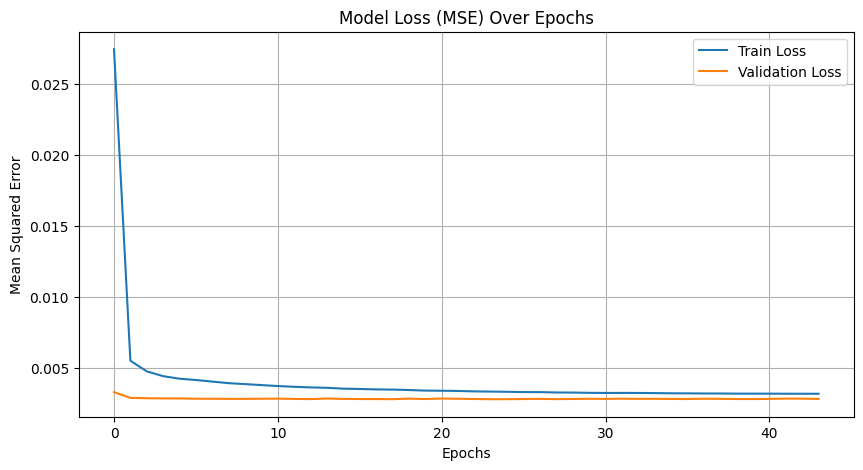

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


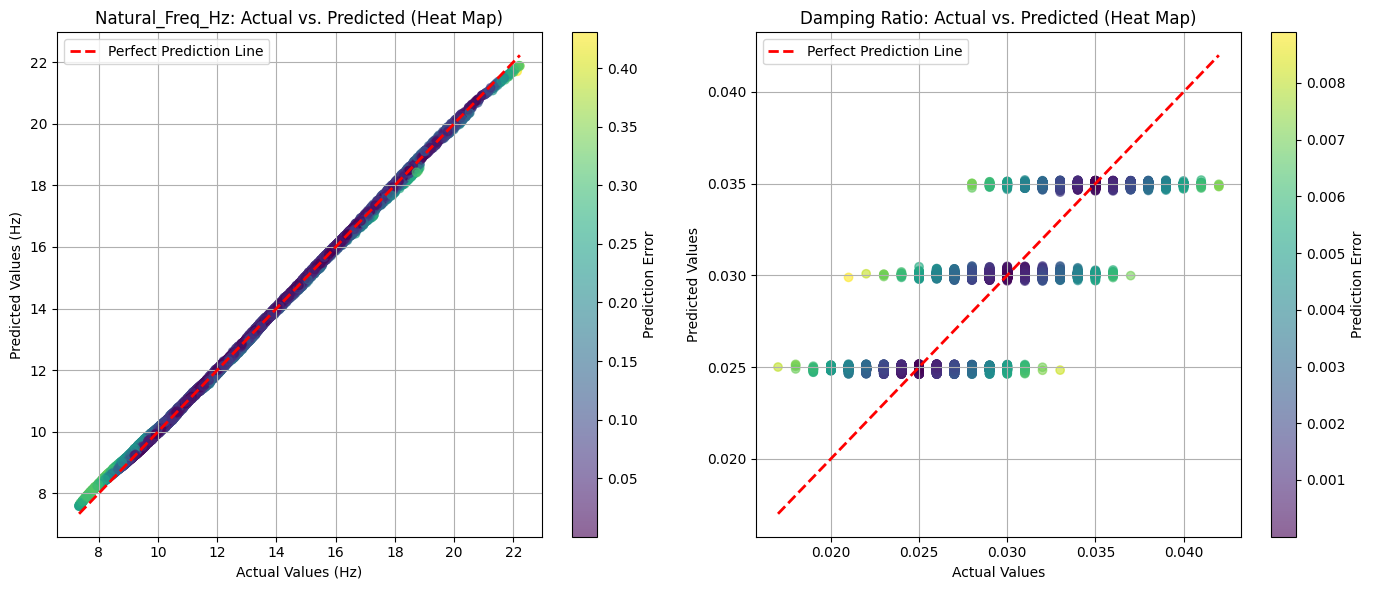


--- R-squared (Performance Score) ---
Natural_Freq_Hz R-squared: 0.9992 (Explains 99.92% of the variance)
Damping Ratio R-squared: 0.8021 (Explains 80.21% of the variance)

--- Sample of Actual vs. Predicted Values ---
   Actual Natural_Freq_Hz  Predicted Natural_Freq_Hz  Actual Damping_Ratio  \
0                   13.58                  13.596345                 0.033   
1                   10.69                  10.674378                 0.026   
2                   13.16                  13.072078                 0.032   
3                   10.75                  10.695658                 0.022   
4                   13.44                  13.399546                 0.031   
5                   12.27                  12.201165                 0.027   
6                   15.15                  15.134795                 0.030   
7                   11.60                  11.573385                 0.028   
8                   15.17                  15.185041                 0.030   


In [9]:
# --- 6. Model Evaluation and Visualization ---
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions and inverse transform them
y_pred_scaled = model.predict(X_test_lstm)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values

# Visualize Actual vs. Predicted values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.6, c=abs(y_true[:, 0] - y_pred[:, 0]), cmap='viridis')
plt.plot([y_true[:, 0].min(), y_true[:, 0].max()], [y_true[:, 0].min(), y_true[:, 0].max()], '--r', linewidth=2, label='Perfect Prediction Line')
plt.title('Natural_Freq_Hz: Actual vs. Predicted (Heat Map)')
plt.xlabel('Actual Values (Hz)')
plt.ylabel('Predicted Values (Hz)')
plt.colorbar(label='Prediction Error')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.6, c=abs(y_true[:, 1] - y_pred[:, 1]), cmap='viridis')
plt.plot([y_true[:, 1].min(), y_true[:, 1].max()], [y_true[:, 1].min(), y_true[:, 1].max()], '--r', linewidth=2, label='Perfect Prediction Line')
plt.title('Damping Ratio: Actual vs. Predicted (Heat Map)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.colorbar(label='Prediction Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Print R-squared (Performance Score) ---
nf_r2 = r2_score(y_true[:, 0], y_pred[:, 0])
dr_r2 = r2_score(y_true[:, 1], y_pred[:, 1])

print("\n--- R-squared (Performance Score) ---")
print(f"Natural_Freq_Hz R-squared: {nf_r2:.4f} (Explains {nf_r2*100:.2f}% of the variance)")
print(f"Damping Ratio R-squared: {dr_r2:.4f} (Explains {dr_r2*100:.2f}% of the variance)")

# --- Display sample of actual vs. predicted values ---
print("\n--- Sample of Actual vs. Predicted Values ---")
sample_indices = np.random.choice(len(y_test), 10, replace=False) # Select 10 random samples
sample_comparison = pd.DataFrame({
    'Actual Natural_Freq_Hz': y_true[sample_indices, 0],
    'Predicted Natural_Freq_Hz': y_pred[sample_indices, 0],
    'Actual Damping_Ratio': y_true[sample_indices, 1],
    'Predicted Damping_Ratio': y_pred[sample_indices, 1]
})
print(sample_comparison)


--- Generating Confusion Matrix for Regression by Discretizing Data ---


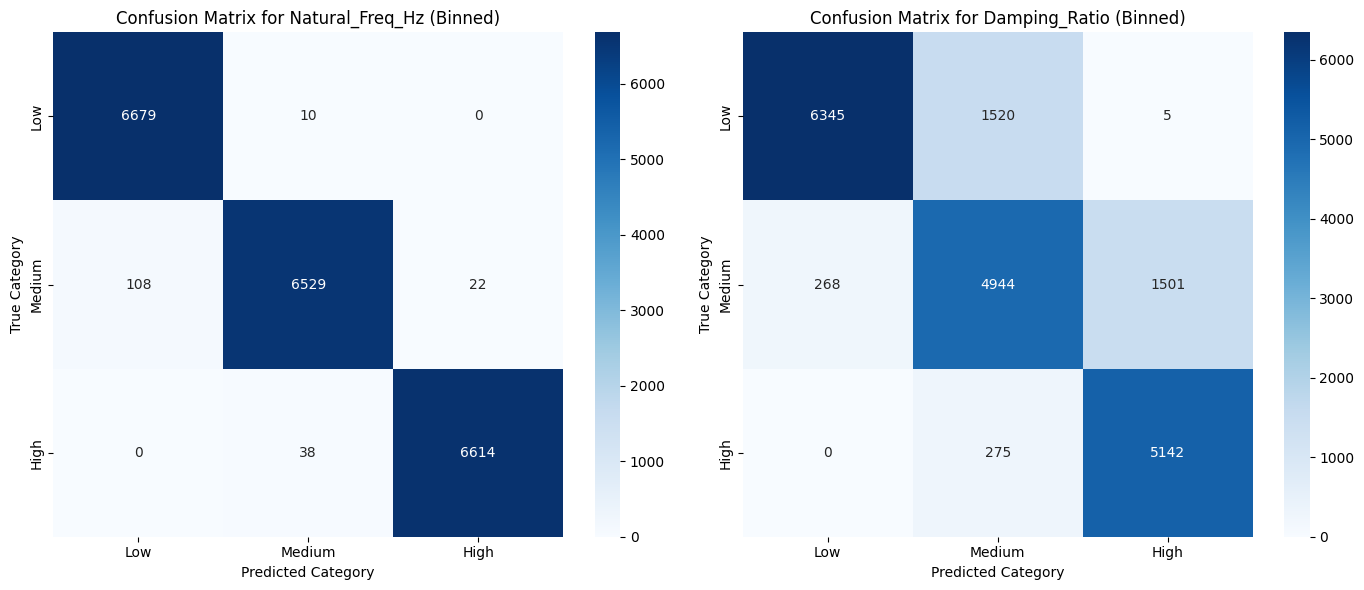

In [10]:
# --- 7. Confusion Matrix by Discretizing Regression Results ---
print("\n--- Generating Confusion Matrix for Regression by Discretizing Data ---")

# Define the category labels
labels = ['Low', 'Medium', 'High']

# --- Part 1: Discretize Natural_Freq_Hz ---
# Create bins for the true and predicted values using the same bin edges
freq_bins = pd.qcut(y_true[:, 0], q=3, labels=labels)
freq_bins_pred = pd.cut(y_pred[:, 0], bins=pd.qcut(y_true[:, 0], q=3, retbins=True)[1], labels=labels, include_lowest=True)

# Generate the confusion matrix for Natural Frequency
cm_freq = confusion_matrix(freq_bins, freq_bins_pred, labels=labels)

# --- Part 2: Discretize Damping_Ratio ---
# Create bins for the true and predicted values using the same bin edges
damp_bins = pd.qcut(y_true[:, 1], q=3, labels=labels)
damp_bins_pred = pd.cut(y_pred[:, 1], bins=pd.qcut(y_true[:, 1], q=3, retbins=True)[1], labels=labels, include_lowest=True)

# Generate the confusion matrix for Damping Ratio
cm_damp = confusion_matrix(damp_bins, damp_bins_pred, labels=labels)

# --- Part 3: Visualize the Confusion Matrices ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_freq, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Natural_Freq_Hz (Binned)')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')

plt.subplot(1, 2, 2)
sns.heatmap(cm_damp, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Damping_Ratio (Binned)')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')

plt.tight_layout()
plt.show()

In [11]:
# --- 8. Model Accuracy from Binned Data (in Percentage) ---

# Calculate Accuracy for Natural_Freq_Hz
correct_freq_predictions = np.trace(cm_freq)
total_freq_predictions = np.sum(cm_freq)
accuracy_freq = correct_freq_predictions / total_freq_predictions

# Calculate Accuracy for Damping_Ratio
correct_damp_predictions = np.trace(cm_damp)
total_damp_predictions = np.sum(cm_damp)
accuracy_damp = correct_damp_predictions / total_damp_predictions

# --- Print the Results in Percentage Format ---
print("\n--- Model Classification Accuracy (from Binned Results) ---")
print(f"Natural_Freq_Hz Binned Accuracy: {accuracy_freq * 100:.2f}%")
print(f"Damping_Ratio Binned Accuracy:   {accuracy_damp * 100:.2f}%")
print("\nThis shows the percentage of times the model correctly predicted whether the value would be in the 'Low', 'Medium', or 'High' range.")


--- Model Classification Accuracy (from Binned Results) ---
Natural_Freq_Hz Binned Accuracy: 99.11%
Damping_Ratio Binned Accuracy:   82.16%

This shows the percentage of times the model correctly predicted whether the value would be in the 'Low', 'Medium', or 'High' range.


In [13]:
# --- Plot Training and Validation Accuracy ---
# Note: Accuracy is not a standard metric for regression, but we can plot the binned accuracy if available from previous steps.
# Assuming 'history' object is available from model training (Cell -cuEORh4qN_S)
if 'history' in locals() and history.history:
    if 'accuracy' in history.history or 'val_accuracy' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy Over Epochs (if available)')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Accuracy metrics not found in training history. This is expected for a pure regression model.")
else:
    print("Model training history ('history' object) not found. Please run the model training cell first.")

Accuracy metrics not found in training history. This is expected for a pure regression model.


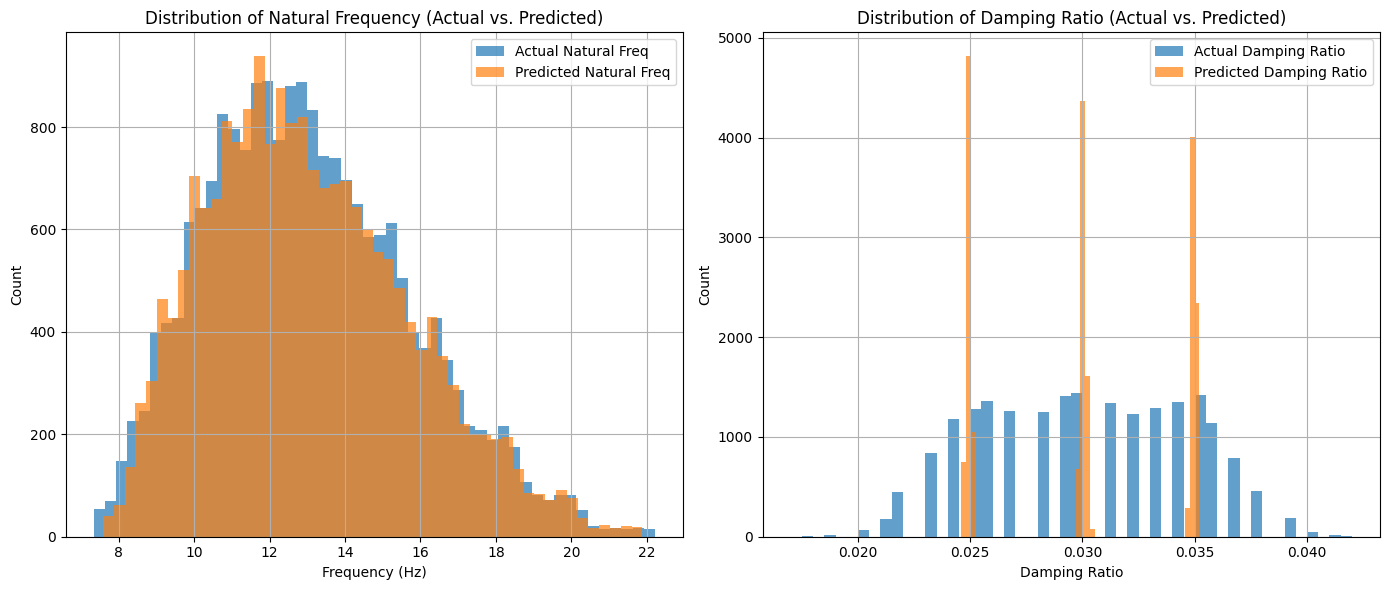

In [14]:
# --- Plot Histograms of Predictions ---
# Assuming 'y_pred' and 'y_true' are available from model evaluation (Cell IvDe89VdqPiJ)
if 'y_pred' in locals() and 'y_true' in locals():
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(y_true[:, 0], bins=50, alpha=0.7, label='Actual Natural Freq')
    plt.hist(y_pred[:, 0], bins=50, alpha=0.7, label='Predicted Natural Freq')
    plt.title('Distribution of Natural Frequency (Actual vs. Predicted)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(y_true[:, 1], bins=50, alpha=0.7, label='Actual Damping Ratio')
    plt.hist(y_pred[:, 1], bins=50, alpha=0.7, label='Predicted Damping Ratio')
    plt.title('Distribution of Damping Ratio (Actual vs. Predicted)')
    plt.xlabel('Damping Ratio')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Actual and predicted values ('y_true', 'y_pred') not found. Please run the model evaluation cell first.")